In [1]:
import numpy as np
import pandas as pd
from time import time
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

# from pre_process import *
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df_general = pd.read_csv('../datasets/scales/random_sample_5w.csv')

In [3]:
def clean_format(train_df):
    train_df[['count', 'city']] = train_df.prov.str.split("_", expand = True)
    train_df['city'] = 'city_' + train_df['city']
    train_df.drop(['prov', 'count'],axis=1,inplace=True)
    return train_df

In [4]:
df_general = clean_format(df_general)
df_general

,date_sequence,hour_sequence,domain_name,isp,node_name,avg_fbt_time,synack1_ratio,reset_ratio,tcp_conntime,icmp_lossrate,...,inner_network_rtt,cpu_util,mem_util,io_await_avg,io_await_max,io_util_avg,io_util_max,ng_traf_level,buffer_rate,city
0,1,4,domain_4,isp_11,node_366,9,0.970097,0.055089,81,0.024353,...,0,0.07442,0.51972,2,2,0.00986,0.0114,0.000,0.000000,city_1
1,1,4,domain_6,isp_11,node_486,6,0.977594,0.050708,102,0.033331,...,0,0.10222,0.70524,11,15,0.06874,0.0920,0.000,0.000000,city_24
2,1,2,domain_6,isp_12,node_842,5,0.974650,0.101399,29,0.036537,...,0,0.10260,0.54760,10,20,0.00910,0.0137,0.030,0.000000,city_33
3,1,1,domain_4,isp_11,node_670,3,1.000000,0.000000,40,0.017712,...,0,0.13320,0.56230,5,5,0.03396,0.0366,0.000,0.078537,city_8
4,1,1,domain_6,isp_11,node_475,5,0.975906,0.042645,180,0.044667,...,0,0.20418,0.62660,11,15,0.10626,0.1268,0.274,0.020514,city_18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,18,22,domain_20,isp_11,node_77,23,0.976227,0.057941,54,0.031973,...,0,0.54076,0.58026,14,16,0.34518,0.3967,0.662,0.021576,city_28
49996,18,22,domain_10,isp_11,node_1059,9,0.982812,0.053232,21,0.014096,...,0,0.15376,0.52894,14,18,0.33376,0.4412,0.694,0.021796,city_7
49997,18,22,domain_16,isp_12,node_66,4,0.962911,0.057733,36,0.111218,...,0,0.10630,0.51322,14,15,0.06578,0.0808,0.124,0.023357,city_12
49998,18,22,domain_12,isp_10,node_1119,20,0.981132,0.096436,31,0.099531,...,0,0.14258,0.52764,15,21,0.21490,0.2391,0.288,0.120059,city_15


In [5]:
from math import sqrt
from collections import Counter

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import LabelEncoder

def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res


def exps(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.exp(res[l])).values)
        res.columns.values[m] = l + '_exp'
        m += 1
    return res


def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res


def calculate_nctt(rtt, loss_rate):
    return 8 * rtt + loss_rate * 8 * 2.5


def calculate_throughput(rtt, loss_rate):
    if (rtt-0.0) < 1e-6 or (loss_rate-0.0) < 1e-6:
        return 10
    return 1460.0 / rtt / 1024 * (1 / sqrt(loss_rate)) # unit MB/s


def calculate_throughput_improved(rtt, loss_rate):
    if (rtt-0.0) < 1e-6 or (loss_rate-0.0) < 1e-6:
        return 10
    return min(4194304.0/rtt/1024, 1/(rtt*sqrt(4/3*loss_rate) +
                                      min(1, 3*sqrt(0.75*loss_rate))*loss_rate*(1+32*loss_rate*loss_rate)))


def get_outliers(df, columns, weight=1.5):
    indices = []
    for col in columns:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_list = df[(df[col] < Q1 - weight * IQR) | (df[col] > Q3 + weight * IQR)].index
        indices.extend(outlier_list)
    indices = Counter(indices)
    result = []
    for i in indices:
        if indices[i] > 2:
            result.append(i)
    return result


def feature_engineering1(df, cat_trans_flag=True):
    # 1. Remove Outliers
    '''
    @Source:
    https://www.kaggle.com/code/joonasyoon/dl-practice-on-regression#Outliers
    '''
    dff = df.copy()
    out_num_lst = ['avg_fbt_time', 'tcp_conntime', 'icmp_rtt', 'inner_network_rtt']
    outliers = get_outliers(dff, out_num_lst)
    dff.drop(index=outliers, axis=0, inplace=True)
    print('Remove {} outlier(s)'.format(len(outliers)))

    # 2. Rolling Window
    for f1 in ['icmp_lossrate', 'synack1_ratio', 'icmp_rtt', 'avg_fbt_time', 'reset_ratio']:
        for f2 in ['domain_name', 'node_name']:
            for i in range(1, 4):
                dff[f1 + '_' + f2 + '_shift_%d' % i] = dff.groupby(f2)[f1].shift(i)
            for i in range(1, 3):
                dff[f1 + '_' + f2 + '_shift_-%d' % i] = dff.groupby(f2)[f1].shift(-i)
            dff[f1 + '_' + f2 + '_mean_decay'] = dff[f1] * 0.5 + dff[f1 + '_' + f2 + '_shift_1'] * 0.3 + \
                                                dff[f1 + '_' + f2 + '_shift_2'] * 0.1 + \
                                                dff[f1 + '_' + f2 + '_shift_3'] * 0.1
        dff[f1 + '_rolling_mean_10'] = dff[f1].rolling(window=10, min_periods=1, center=True).mean()
        dff[f1 + '_rolling_mean_30'] = dff[f1].rolling(window=30, min_periods=1, center=True).mean()
    dff = dff.fillna(0)

    df_features = dff.copy()
    # df_features[['First', 'domain']] = df_features.domain_name.str.split("_", expand=True)
    # df_features.drop(labels=['First'], axis=1, inplace=True)
    # df_features[['First', 'node']] = df_features.node_name.str.split("_", expand=True)
    # df_features.drop(labels=['First'], axis=1, inplace=True)
    # df_features['domain'] = df_features['domain'].astype('int64')
    # df_features['node'] = df_features['node'].astype('int64')

    df_features['odd_synack1_ratio'] = 1 - df_features['synack1_ratio']
    df_features['odd_icmp_lossrate'] = 1 - df_features['icmp_lossrate']
    df_features['odd_ratio_499_5xx'] = 1 - df_features['ratio_499_5xx']
    df_features['odd_ng_traf_level'] = 1 - df_features['ng_traf_level']
    df_features['odd_inner_network_droprate'] = 1 - df_features['inner_network_droprate']

    df_features["nctt"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_nctt(*x), axis=1)
    df_features["bw_up"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_throughput(*x), axis=1)
    df_features["bw_im"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_throughput_improved(*x),
                                                                            axis=1)
    # 3. Skew transform
    numeric = ['avg_fbt_time', 'tcp_conntime', 'icmp_rtt', 'synack1_ratio', 'reset_ratio',
               'tcp_conntime', 'icmp_lossrate',  'ratio_499_5xx',
               'inner_network_droprate', 'cpu_util', 'mem_util',
               'io_await_avg', 'io_await_max', 'io_util_avg', 'io_util_max','ng_traf_level']
    skew_features = df_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index
    print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
    for i in skew_index:
        df_features[i] = boxcox1p(df_features[i], boxcox_normmax(df_features[i] + 1))

    df_features['total_delay'] = (df_features['avg_fbt_time'] + df_features['tcp_conntime'] + df_features['icmp_rtt'])
    df_features['total_io_delay'] = df_features['io_await_avg'] + df_features['io_await_max']
    df_features['delta_io_delay'] = df_features['io_await_max'] - df_features['io_await_avg']
    df_features['delta_io_util'] = df_features['io_util_max'] - df_features['io_util_avg']
    df_features['avg_util'] = (0.5 * df_features['cpu_util']) + (0.5 * df_features['mem_util'])

    log_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_rtt', 'icmp_lossrate', 'io_util_avg',
                    'avg_fbt_time', 'synack1_ratio', 'tcp_conntime', 'inner_network_droprate', 'cpu_util',
                    'io_util_max','total_delay', 'delta_io_util', 'avg_util', 'nctt', 'bw_up', 'bw_im']
    df_features = logs(df_features, log_features)
    # exp_features = mi_reg_lst.remove('node')
    exp_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_lossrate', 'io_util_avg',
                    'synack1_ratio', 'inner_network_droprate', 'cpu_util', 'io_util_max',
                    'total_delay', 'delta_io_util', 'avg_util']
    df_features = exps(df_features, exp_features)
    squared_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_lossrate', 'io_util_avg',
                        'synack1_ratio', 'inner_network_droprate', 'cpu_util', 'io_util_max',
                        'total_delay', 'delta_io_util', 'avg_util']
    df_features = squares(df_features, squared_features)

    df_features.drop(labels=['inner_network_rtt'], axis=1, inplace=True)
    df_features['id'] = df_features['node_name'] + df_features['domain_name']
    df_features['no'] = df_features.groupby(['id'])['buffer_rate'].cumcount()
    df_features['no_max'] = df_features.groupby(['id'])['no'].transform('max')
    # Categorical
    if cat_trans_flag:
        for f in ['domain_name', 'node_name', 'city', 'isp', 'id']:
            le = LabelEncoder()
            le.fit(df_features[f])
            dic = {x: le.transform([x])[0] for x in df_features[f].unique()}
            df_features[f] = df_features[f].map(dic)
    df_labels = df_features['buffer_rate'].reset_index(drop=True)
    df_features = df_features.drop(['buffer_rate'], axis=1)
    return df_features, df_labels

In [6]:
df_general_features, df_general_labels = feature_engineering1(df_general)

Remove 23 outlier(s)
There are 14 numerical features with Skew > 0.5 :


In [7]:
general_seed = 42
general_lg_best = LGBMRegressor(objective='mean_absolute_error',
                            boosting_type='dart',   
                            max_depth=10,
                            max_bin=255,
                            n_estimators=3000,
                            learning_rate=0.01,
                            bagging_seed=general_seed,
                            feature_fraction_seed=general_seed,
                            data_random_seed=general_seed,
                            verbose=-1,
                            device="gpu",
                            gpu_platform_id=0,
                            gpu_device_id=2,
                            random_state=general_seed)
start1 = time()
general_lg_best.fit(df_general_features.values, df_general_labels.values)
end1 = time()

In [8]:
df_general_lst = df_general.columns.to_list()

feature_importance             = pd.DataFrame()
feature_importance['fea_name'] = df_general_features.columns.to_list()
feature_importance['fea_imp']  = general_lg_best.feature_importances_
general_importance = feature_importance.loc[feature_importance['fea_name'].isin(df_general_lst)].copy()
general_importance.sort_values('fea_imp',ascending = False,inplace=True)
general_importance

,fea_name,fea_imp
20,city,11210
1,hour_sequence,6320
2,domain_name,5378
7,reset_ratio,3971
3,isp,2769
19,ng_traf_level,2015
4,node_name,1732
6,synack1_ratio,1730
9,icmp_lossrate,1488
0,date_sequence,1364


In [9]:
sum(general_importance['fea_imp'])

43697

In [10]:
general_importance['fea_imp'] = general_importance['fea_imp'] / sum(general_importance['fea_imp'])*100
general_importance

,fea_name,fea_imp
20,city,25.653935
1,hour_sequence,14.463235
2,domain_name,12.307481
7,reset_ratio,9.087580
3,isp,6.336819
19,ng_traf_level,4.611301
4,node_name,3.963659
6,synack1_ratio,3.959082
9,icmp_lossrate,3.405268
0,date_sequence,3.121496


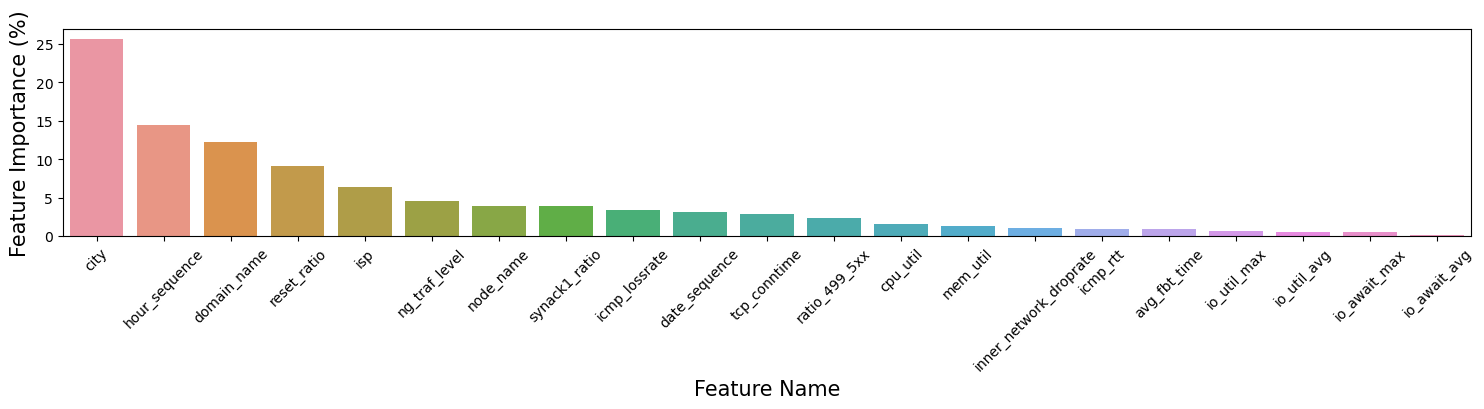

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=[15,4],dpi=100)
labels = general_importance['fea_name'].to_list()
ax = sns.barplot(x =labels, y = general_importance['fea_imp'])
ax.set_xticklabels(labels = labels, rotation = 45, fontsize=10)
# ax.set_yticklabels(fontsize = 15)
plt.xlabel('Feature Name',fontsize=15)
plt.ylabel('Feature Importance (%)',fontsize=15)
plt.tight_layout()

In [12]:
seed = 4

df = pd.read_csv('../datasets/domain_specific/domain_specific_isp_11domain_10prov_18.csv')
df = clean_format(df)
# s1, s2, s3 = 7952, 14309, 20397
s = len(df) // 3
train_df = df.iloc[:s, :].sample(n=8000, random_state=seed)
train_df.sort_index(ascending=True, inplace=True)
test_df1 = df.iloc[s:s*2, :].sample(n=8000, random_state=seed)
test_df1.sort_index(ascending=True, inplace=True)
test_df2 = df.iloc[s*2:s*3, :].sample(n=8000, random_state=seed)
test_df2.sort_index(ascending=True, inplace=True)

In [13]:
def feature_engineering(df, cat_trans_flag=True):
    # 1. Remove Outliers
    '''
    @Source:
    https://www.kaggle.com/code/joonasyoon/dl-practice-on-regression#Outliers
    '''
    dff = df.copy()
    # out_num_lst = ['avg_fbt_time', 'tcp_conntime', 'icmp_rtt', 'inner_network_rtt']
    # outliers = get_outliers(dff, out_num_lst)
    # dff.drop(index=outliers, axis=0, inplace=True)
    # print('Remove {} outlier(s)'.format(len(outliers)))

    # 2. Rolling Window
    for f1 in ['icmp_lossrate', 'synack1_ratio', 'icmp_rtt', 'avg_fbt_time', 'reset_ratio']:
        for f2 in ['domain_name', 'node_name']:
            for i in range(1, 4):
                dff[f1 + '_' + f2 + '_shift_%d' % i] = dff.groupby(f2)[f1].shift(i)
            for i in range(1, 3):
                dff[f1 + '_' + f2 + '_shift_-%d' % i] = dff.groupby(f2)[f1].shift(-i)
            dff[f1 + '_' + f2 + '_mean_decay'] = dff[f1] * 0.5 + dff[f1 + '_' + f2 + '_shift_1'] * 0.3 + \
                                                dff[f1 + '_' + f2 + '_shift_2'] * 0.1 + \
                                                dff[f1 + '_' + f2 + '_shift_3'] * 0.1
        dff[f1 + '_rolling_mean_10'] = dff[f1].rolling(window=10, min_periods=1, center=True).mean()
        dff[f1 + '_rolling_mean_30'] = dff[f1].rolling(window=30, min_periods=1, center=True).mean()
    dff = dff.fillna(0)

    df_features = dff.copy()
    # df_features[['First', 'domain']] = df_features.domain_name.str.split("_", expand=True)
    # df_features.drop(labels=['First'], axis=1, inplace=True)
    # df_features[['First', 'node']] = df_features.node_name.str.split("_", expand=True)
    # df_features.drop(labels=['First'], axis=1, inplace=True)
    # df_features['domain'] = df_features['domain'].astype('int64')
    # df_features['node'] = df_features['node'].astype('int64')

    df_features['odd_synack1_ratio'] = 1 - df_features['synack1_ratio']
    df_features['odd_icmp_lossrate'] = 1 - df_features['icmp_lossrate']
    df_features['odd_ratio_499_5xx'] = 1 - df_features['ratio_499_5xx']
    df_features['odd_ng_traf_level'] = 1 - df_features['ng_traf_level']
    df_features['odd_inner_network_droprate'] = 1 - df_features['inner_network_droprate']

    df_features["nctt"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_nctt(*x), axis=1)
    df_features["bw_up"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_throughput(*x), axis=1)
    df_features["bw_im"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_throughput_improved(*x),
                                                                            axis=1)
    # 3. Skew transform
    numeric = ['avg_fbt_time', 'tcp_conntime', 'icmp_rtt', 'synack1_ratio', 'reset_ratio',
               'tcp_conntime', 'icmp_lossrate',  'ratio_499_5xx','inner_network_droprate', 'cpu_util', 'mem_util',
               'io_await_avg', 'io_await_max', 'io_util_avg', 'io_util_max','ng_traf_level']
    skew_features = df_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index
    print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
    for i in skew_index:
        df_features[i] = boxcox1p(df_features[i], boxcox_normmax(df_features[i] + 1))

    df_features['total_delay'] = (df_features['avg_fbt_time'] + df_features['tcp_conntime'] + df_features['icmp_rtt'])
    df_features['total_io_delay'] = df_features['io_await_avg'] + df_features['io_await_max']
    df_features['delta_io_delay'] = df_features['io_await_max'] - df_features['io_await_avg']
    df_features['delta_io_util'] = df_features['io_util_max'] - df_features['io_util_avg']
    df_features['avg_util'] = (0.5 * df_features['cpu_util']) + (0.5 * df_features['mem_util'])

    log_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_rtt', 'icmp_lossrate', 'io_util_avg',
                    'avg_fbt_time', 'synack1_ratio', 'tcp_conntime', 'inner_network_droprate', 'cpu_util',
                    'io_util_max','total_delay', 'delta_io_util', 'avg_util', 'nctt', 'bw_up', 'bw_im']
    df_features = logs(df_features, log_features)
    # exp_features = mi_reg_lst.remove('node')
    exp_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_lossrate', 'io_util_avg',
                    'synack1_ratio', 'inner_network_droprate', 'cpu_util', 'io_util_max',
                    'total_delay', 'delta_io_util', 'avg_util']
    df_features = exps(df_features, exp_features)
    squared_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_lossrate', 'io_util_avg',
                        'synack1_ratio', 'inner_network_droprate', 'cpu_util', 'io_util_max',
                        'total_delay', 'delta_io_util', 'avg_util']
    df_features = squares(df_features, squared_features)

    df_features.drop(labels=['inner_network_rtt'], axis=1, inplace=True)
    df_features['id'] = df_features['node_name'] + df_features['domain_name']
    df_features['no'] = df_features.groupby(['id'])['buffer_rate'].cumcount()
    df_features['no_max'] = df_features.groupby(['id'])['no'].transform('max')
    # Categorical
    if cat_trans_flag:
        for f in ['domain_name', 'node_name', 'city', 'isp', 'id']:
            le = LabelEncoder()
            le.fit(df_features[f])
            dic = {x: le.transform([x])[0] for x in df_features[f].unique()}
            df_features[f] = df_features[f].map(dic)
    df_labels = df_features['buffer_rate'].reset_index(drop=True)
    df_features = df_features.drop(['buffer_rate'], axis=1)
    return df_features, df_labels*100

In [14]:
train_df_features, train_df_labels = feature_engineering(train_df, False)
test_df1_features, test_df1_labels = feature_engineering(test_df1, False)
test_df2_features, test_df2_labels = feature_engineering(test_df2, False)

df['id'] = df['node_name'] + df['domain_name']
for f in ['domain_name', 'city', 'isp', 'node_name', 'id']:
    le = LabelEncoder()
    le.fit(df[f])
    dic1 = {x: le.transform([x])[0] for x in df[f].unique()}
    train_df_features[f] = train_df_features[f].map(dic1)
    test_df1_features[f] = test_df1_features[f].map(dic1)
    test_df2_features[f] = test_df2_features[f].map(dic1)

There are 13 numerical features with Skew > 0.5 :
There are 14 numerical features with Skew > 0.5 :
There are 13 numerical features with Skew > 0.5 :


In [15]:
lg_best = LGBMRegressor(objective='mean_absolute_error',
                        boosting_type='dart',
                        # feature_name=df_features.columns.to_list(),
                        # categorical_feature=['domain_name', 'node_name', 'prov', 'isp', 'id'],
                        # categorical_feature='name:domain_name, node_name, prov, isp, id',
                        #categorical_feature='2,3,4,5,143',
                        max_depth=5,
                        max_bin=255,
                        # num_leaves=random_search.best_params_["num_leaves"],
                        n_estimators=3000,
                        # min_child_samples=random_search.best_params_["min_child_samples"],
                        # min_child_weight=random_search.best_params_["min_child_weight"],
                        # feature_fraction=random_search.best_params_["feature_fraction"],
                        # subsample=random_search.best_params_["subsample"],
                        # bagging_freq=random_search.best_params_["bagging_freq"],
                        # reg_alpha=random_search.best_params_["reg_alpha"],
                        # reg_lambda=random_search.best_params_["reg_lambda"],
                        # learning_rate=random_search.best_params_["learning_rate"],
                        learning_rate=0.01,
                        bagging_seed=seed,
                        feature_fraction_seed=seed,
                        data_random_seed=seed,
                        verbose=-1,
                        #device="gpu",
                        #gpu_platform_id=0,
                        #gpu_device_id=0,
                        random_state=seed)

start1 = time()
lg_best.fit(train_df_features.values, train_df_labels.values)
end1 = time()

In [16]:
train_df_features.columns.to_list()

['date_sequence',
 'hour_sequence',
 'domain_name',
 'isp',
 'node_name',
 'avg_fbt_time',
 'synack1_ratio',
 'reset_ratio',
 'tcp_conntime',
 'icmp_lossrate',
 'icmp_rtt',
 'ratio_499_5xx',
 'inner_network_droprate',
 'cpu_util',
 'mem_util',
 'io_await_avg',
 'io_await_max',
 'io_util_avg',
 'io_util_max',
 'ng_traf_level',
 'city',
 'icmp_lossrate_domain_name_shift_1',
 'icmp_lossrate_domain_name_shift_2',
 'icmp_lossrate_domain_name_shift_3',
 'icmp_lossrate_domain_name_shift_-1',
 'icmp_lossrate_domain_name_shift_-2',
 'icmp_lossrate_domain_name_mean_decay',
 'icmp_lossrate_node_name_shift_1',
 'icmp_lossrate_node_name_shift_2',
 'icmp_lossrate_node_name_shift_3',
 'icmp_lossrate_node_name_shift_-1',
 'icmp_lossrate_node_name_shift_-2',
 'icmp_lossrate_node_name_mean_decay',
 'icmp_lossrate_rolling_mean_10',
 'icmp_lossrate_rolling_mean_30',
 'synack1_ratio_domain_name_shift_1',
 'synack1_ratio_domain_name_shift_2',
 'synack1_ratio_domain_name_shift_3',
 'synack1_ratio_domain_name

In [17]:
df_lst = df.columns.to_list()

feature_importance             = pd.DataFrame()
feature_importance['fea_name'] = train_df_features.columns.to_list()
feature_importance['fea_imp']  = lg_best.feature_importances_
df_feature_importance = feature_importance.loc[feature_importance['fea_name'].isin(df_lst)]
df_feature_importance

,fea_name,fea_imp
0,date_sequence,1963
1,hour_sequence,2589
2,domain_name,0
3,isp,0
4,node_name,81
5,avg_fbt_time,237
6,synack1_ratio,1226
7,reset_ratio,1453
8,tcp_conntime,89
9,icmp_lossrate,832


In [18]:
df_feature_importance.sort_values('fea_imp',ascending = False,inplace=True)
df_feature_importance

,fea_name,fea_imp
1,hour_sequence,2589
13,cpu_util,2246
0,date_sequence,1963
18,io_util_max,1858
7,reset_ratio,1453
6,synack1_ratio,1226
11,ratio_499_5xx,1185
16,io_await_max,1171
9,icmp_lossrate,832
14,mem_util,748


In [19]:
df_feature_importance['fea_imp'] = df_feature_importance['fea_imp'] / sum(df_feature_importance['fea_imp'])*100
df_feature_importance

,fea_name,fea_imp
1,hour_sequence,14.854553
13,cpu_util,12.886568
0,date_sequence,11.262838
18,io_util_max,10.660394
7,reset_ratio,8.336680
6,synack1_ratio,7.034253
11,ratio_499_5xx,6.799013
16,io_await_max,6.718687
9,icmp_lossrate,4.773653
14,mem_util,4.291698


In [20]:
len(df_feature_importance['fea_name'].to_list())

22

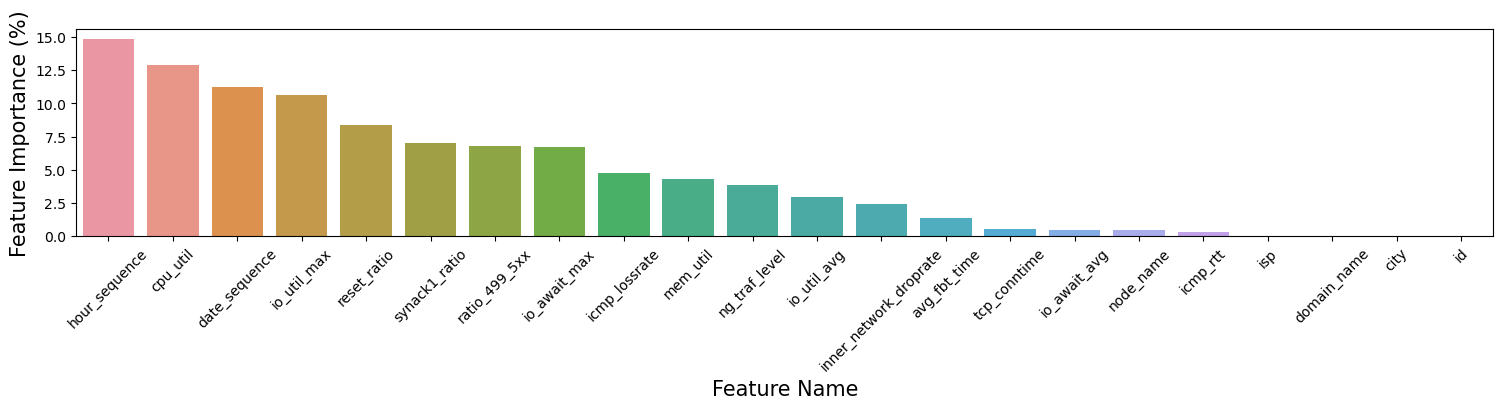

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=[15,4],dpi=100)
labels = df_feature_importance['fea_name'].to_list()
ax = sns.barplot(x =labels, y = df_feature_importance['fea_imp'])
ax.set_xticklabels(labels = labels, rotation = 45, fontsize=10)
# ax.set_yticklabels(fontsize = 15)
plt.xlabel('Feature Name',fontsize=15)
plt.ylabel('Feature Importance (%)',fontsize=15)
plt.tight_layout()

In [22]:
df_feature_importance

,fea_name,fea_imp
1,hour_sequence,14.854553
13,cpu_util,12.886568
0,date_sequence,11.262838
18,io_util_max,10.660394
7,reset_ratio,8.336680
6,synack1_ratio,7.034253
11,ratio_499_5xx,6.799013
16,io_await_max,6.718687
9,icmp_lossrate,4.773653
14,mem_util,4.291698


In [23]:
df_feature_importance.drop(df_feature_importance.index[-1], inplace=True)
df_feature_importance

,fea_name,fea_imp
1,hour_sequence,14.854553
13,cpu_util,12.886568
0,date_sequence,11.262838
18,io_util_max,10.660394
7,reset_ratio,8.336680
6,synack1_ratio,7.034253
11,ratio_499_5xx,6.799013
16,io_await_max,6.718687
9,icmp_lossrate,4.773653
14,mem_util,4.291698


In [24]:
len(df_feature_importance['fea_name'].to_list())

21

In [25]:
general_labels = general_importance['fea_name'].to_list()
len(general_labels)

21

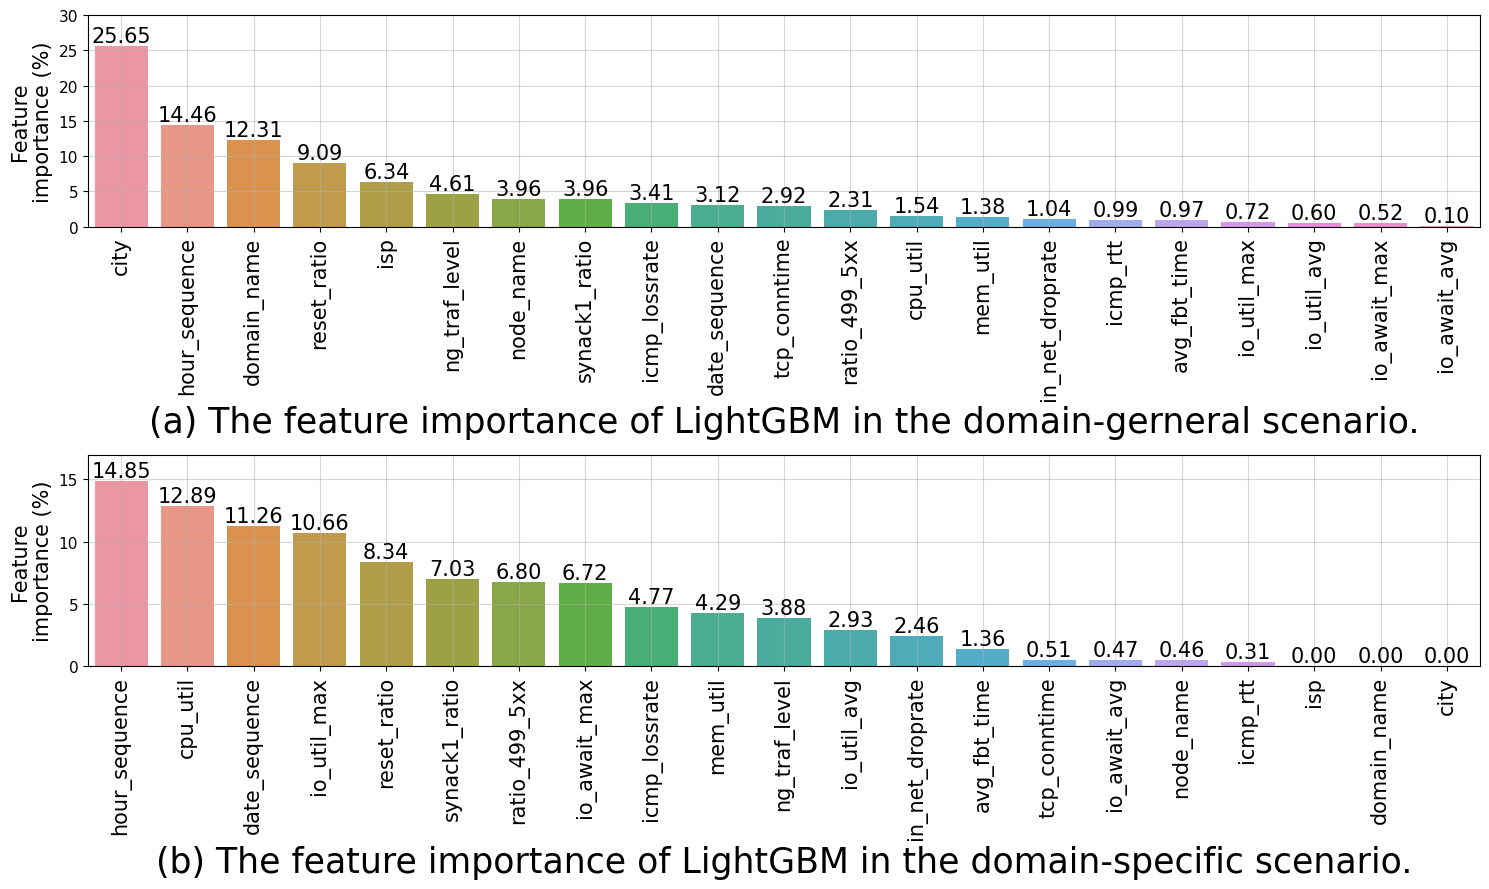

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(15,9), dpi=100)
label_size = 15

A_as_ticklabel = [f"{a:.2f}" for a in general_importance['fea_imp'].values]
general_labels = general_importance['fea_name'].to_list()
general_labels[14] = 'in_net_droprate'
ax1 = sns.barplot(x =general_labels, y = general_importance['fea_imp'], ax=axes[0])
ax1.grid(alpha=0.5)
# ax1.set_yticklabels(fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.set_xticklabels(labels = general_labels, rotation = 90, fontsize=label_size)
# ax1.set_yscale('log')
ax1.bar_label(ax1.containers[0], label_type='edge', labels=A_as_ticklabel, fontsize=15)
ax1.set_xlabel('(a) The feature importance of LightGBM in the domain-gerneral scenario.' , fontsize=25)
ax1.set_ylabel('Feature\nimportance (%)', fontsize=15)
ax1.set_ylim(top=30)

A_as_ticklabe2 = [f"{a:.2f}" for a in df_feature_importance['fea_imp'].values]
sepcific_labels = df_feature_importance['fea_name'].to_list()
sepcific_labels[12] = 'in_net_droprate'
ax2 = sns.barplot(x =sepcific_labels, y = df_feature_importance['fea_imp'], ax=axes[1])
ax2.grid(alpha=0.5)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.set_xticklabels(labels = sepcific_labels, rotation = 90, fontsize=label_size)
# ax2.set_yscale('log')
ax2.bar_label(ax2.containers[0], label_type='edge', labels=A_as_ticklabe2, fontsize=15)
ax2.set_xlabel('(b) The feature importance of LightGBM in the domain-specific scenario.' , fontsize=25)
ax2.set_ylabel('Feature\nimportance (%)', fontsize=15)
ax2.set_ylim(top=17)

fig.tight_layout()
# fig.savefig('./lightgbm_fea_imp_2.pdf')

- https://www.codecademy.com/article/seaborn-design-ii
- https://seaborn.pydata.org/tutorial/color_palettes.html